# What is the first mass transfer case for different potential DCO systems? 



In [6]:
import numpy as np
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys
from matplotlib.gridspec import GridSpec


home_dir = os.path.expanduser("~") 
compas_v = "v03.01.02"# "v02.46.01/"#v02.35.02/"
sim_name =  'NewWinds_RemFryer2012_noWRwinds' #'OldWinds_RemFryer2012'#  'NewWinds_RemFryer2012_noNSBHkick'#'OldWinds_RemFryer2012'#  
channel_key     = '_stable' #'', '_stable' # '_CE' '_CHE'  '' 

datar_root = f"{home_dir}/ceph/CompasOutput/{compas_v}"

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))



In [7]:
####################################
# Take the base potential DCO progenitor table
prog_table_name = f'potential_DCO_progenitors_Allinfo{channel_key}.h5'

if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(f'{datar_root}/{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())
else:
    print(f'error, {datar_root}/{sim_name}/{prog_table_name} does not exist, you should make it using "DataManipulation.ipynb" first')

potential_DCO_progenitors.reset_index(drop=True, inplace=True)
    

### Split your table between merging BBH/BHNS/NSNS

with h5.File(f'{datar_root}/{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
    DCO = All_data['BSE_Double_Compact_Objects']
    st1 = DCO['Stellar_Type(1)'][()]
    st2 = DCO['Stellar_Type(2)'][()]
    dco_merger = DCO['Merges_Hubble_Time'][()]  
    DCO_seed = DCO['SEED'][()]
    # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
    BBH_bool = np.logical_and(st1 == 14,st2 == 14)
    BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                            np.logical_and(st1 == 14,st2 == 13) )
    NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
    merger_bool = dco_merger == 1

    # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
    potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
    potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
    potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 259236 entries, 0 to 259235
Columns: 113 entries, SEED to SN_star2_Orb_Velocity<SN
dtypes: float64(100), int32(2), object(3), uint32(1), uint64(1), uint8(6)
memory usage: 212.1+ MB
Table exists, reading in...  None


## Plot stellar mergers for each of the DCO flavours

In [8]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)


metallicities [0.0001     0.00017321 0.0003     0.00054772 0.001      0.002
 0.004      0.00632456 0.01       0.01414214 0.02       0.03      ]


In [9]:
def get_MT_numbers(table = potential_DCO_progenitors, first_second_mt = 'firstMT_'):

    """_summary_
    Args:

    first_second_mt = 'firstMT_' or  'star2_firstMT_'

    Returns:
        _type_: _description_
    """

    # CASE A: Stellar type1/2 == 1 for star MT 1/2
    case_A_bool1    = np.logical_and(table[f'{first_second_mt}Stellar_Type(1)<MT'] == 1, table[f'{first_second_mt}RLOF(1)>MT'] == 1)
    case_A_bool2    = np.logical_and(table[f'{first_second_mt}Stellar_Type(2)<MT'] == 1,  table[f'{first_second_mt}RLOF(2)>MT'] == 1)
    case_A_bool     = np.logical_or(case_A_bool1, case_A_bool2)
    table.loc[case_A_bool, 'MT1_case_A_donor'] = True
    table.loc[~case_A_bool, 'MT1_case_A_donor'] = False

    # CASE B: Stellar type1/2 == 2 for star MT 1/2
    case_B_bool1    = np.logical_and(table[f'{first_second_mt}Stellar_Type(1)<MT'] == 2, table[f'{first_second_mt}RLOF(1)>MT'] == 1)
    case_B_bool2    = np.logical_and(table[f'{first_second_mt}Stellar_Type(2)<MT'] == 2, table[f'{first_second_mt}RLOF(2)>MT'] == 1)
    case_B_bool     = np.logical_or(case_B_bool1, case_B_bool2)
    table.loc[case_B_bool, 'MT1_case_B_donor'] = True
    table.loc[~case_B_bool, 'MT1_case_B_donor'] = False

    # CASE C: Stellar type1/2 > 2 for star MT 1/2
    case_C_bool1    = np.logical_and(table[f'{first_second_mt}Stellar_Type(1)<MT'] > 2, table[f'{first_second_mt}RLOF(1)>MT'] == 1)
    case_C_bool2    = np.logical_and(table[f'{first_second_mt}Stellar_Type(2)<MT'] > 2, table[f'{first_second_mt}RLOF(2)>MT'] == 1)
    case_C_bool     = np.logical_or(case_C_bool1, case_C_bool2)
    table.loc[case_C_bool, 'MT1_case_C_donor'] = True
    table.loc[~case_C_bool, 'MT1_case_C_donor'] = False

    # Was the mass transfer that lead to the merger, stable or unstable MT?
    firstMT_stable = table[f'{first_second_mt}CEE>MT'] == 0
    # table[f'{first_second_mt}stable'] = np.full(len(table), False)
    table.loc[~firstMT_stable, f'{first_second_mt}stable'] = False
    table.loc[firstMT_stable, f'{first_second_mt}stable'] = True

    ################################################
    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog          = grouped_byZ.size() # total number in this table (per Z)
    N_mergers               = grouped_byZ['Merger'].apply(lambda x: (x==1).sum()) # number of stellar mergers in total
    
    # print('N_mergers', N_mergers)
    # print('N_first_mt1_is_merger',N_first_mt1_is_merger, 'N_first_mt2_is_merger', N_first_mt2_is_merger)
    # print('difference: ', N_mergers - (N_first_mt1_is_merger + N_first_mt2_is_merger))

    N_optimistic_CE     = grouped_byZ['Optimistic_CE'].apply(lambda x: (x==1).sum()) # optimistic CE (= CE from case B donor)
    N_merger_at_birth   = grouped_byZ['Merger_At_Birth'].apply(lambda x: (x==1).sum()) # stars that merge at birth
    N_CHE_at_birth      = grouped_byZ['CH_on_MS(1)'].apply(lambda x: (x==1).sum()) # stars that are CHE at birth

    N_caseA_firstmt         = grouped_byZ['MT1_case_A_donor'].apply(lambda x: (x==1).sum())
    N_caseA_firstmt_stable  = grouped_byZ.apply(lambda x: ((x['MT1_case_A_donor']==1) & (x[f'{first_second_mt}stable']==True)).sum())
    N_caseA_firstmt_CE      = grouped_byZ.apply(lambda x: ((x['MT1_case_A_donor']==1) & (x[f'{first_second_mt}stable']==False)).sum())

    N_caseB_firstmt         = grouped_byZ['MT1_case_B_donor'].apply(lambda x: (x==1).sum())
    N_caseB_firstmt_stable  = grouped_byZ.apply(lambda x: ((x['MT1_case_B_donor']==1) & (x[f'{first_second_mt}stable']==True)).sum())
    N_caseB_firstmt_CE      = grouped_byZ.apply(lambda x: ((x['MT1_case_B_donor']==1) & (x[f'{first_second_mt}stable']==False)).sum())

    N_caseC_firstmt         = grouped_byZ['MT1_case_C_donor'].apply(lambda x: (x==1).sum())
    N_caseC_firstmt_stable  = grouped_byZ.apply(lambda x: ((x['MT1_case_C_donor']==1) & (x[f'{first_second_mt}stable']==True)).sum())
    N_caseC_firstmt_CE      = grouped_byZ.apply(lambda x: ((x['MT1_case_C_donor']==1) & (x[f'{first_second_mt}stable']==False)).sum())

    case_ABC = [N_caseA_firstmt, N_caseA_firstmt_stable, N_caseA_firstmt_CE, N_caseB_firstmt, N_caseB_firstmt_stable, N_caseB_firstmt_CE, N_caseC_firstmt, N_caseC_firstmt_stable, N_caseC_firstmt_CE]

    return  N_tot_DCO_prog, N_mergers, N_optimistic_CE, N_merger_at_birth, N_CHE_at_birth, case_ABC


N_tot_DCO_prog, N_mergers, N_optimistic_CE, N_merger_at_birth, N_CHE_at_birth, case_ABC = get_MT_numbers(table = potential_DCO_progenitors)

N_caseA_firstmt, N_caseA_firstmt_stable, N_caseA_firstmt_CE, N_caseB_firstmt, N_caseB_firstmt_stable, N_caseB_firstmt_CE, N_caseC_firstmt, N_caseC_firstmt_stable, N_caseC_firstmt_CE = case_ABC


metallicities [0.0001     0.00017321 0.0003     0.00054772 0.001      0.002
 0.004      0.00632456 0.01       0.01414214 0.02       0.03      ]


/tmp/ipykernel_515057/1955191933.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.loc[case_A_bool, 'MT1_case_A_donor'] = True
/tmp/ipykernel_515057/1955191933.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.loc[case_B_bool, 'MT1_case_B_donor'] = True
/tmp/ipykernel_515057/1955191933.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

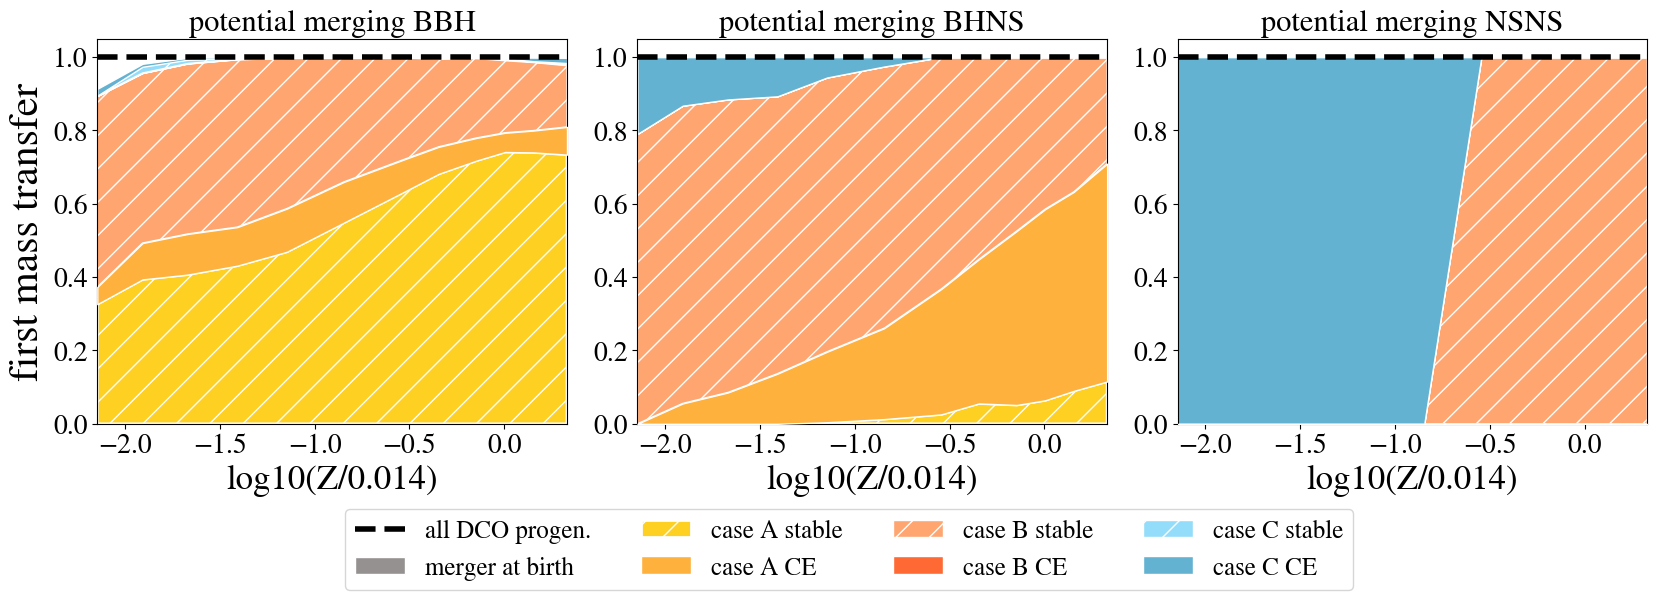

In [10]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)

first_or_second_mt = 'firstMT_' #'firstMT_' # 'star2_firstMT_' # 


###########################################
# Create a figure
fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)

# Create 3 small subplots on a line
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# List of panda tables of pot DCO progenitors
titles = ["BBH", "BHNS", "NSNS"]
dfs = [potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Loop over the axes and dataframes
for ax, df, title in zip(axes, dfs, titles):
    ax.plot(1,1)
    N_tot_DCO_prog, N_mergers, N_optimistic_CE, N_merger_at_birth, N_CHE_at_birth, case_ABC = get_MT_numbers(table = df, first_second_mt = first_or_second_mt)
    N_caseA_firstmt, N_caseA_firstmt_stable, N_caseA_firstmt_CE, N_caseB_firstmt, N_caseB_firstmt_stable, N_caseB_firstmt_CE, N_caseC_firstmt, N_caseC_firstmt_stable, N_caseC_firstmt_CE = case_ABC

    # Normalize or abs numbers?
    norm = N_tot_DCO_prog # 1. # N_tot_DCO_prog

    ax.plot(Z_Zsun, N_tot_DCO_prog/norm, color='k', label='all DCO progen.', ls = '--', lw = 4,alpha = 1)

    bottom = np.zeros(len(Z_Zsun))

    # we count stellar merger at birht as a 'first mass transfer'
    if first_or_second_mt == 'firstMT_':
        # Stellar merger at birth 
        ax.fill_between(Z_Zsun, bottom/norm, N_merger_at_birth/norm, color='#959190', edgecolor='white', lw = 1, label='merger at birth', alpha = 1)
        bottom += N_merger_at_birth

    # Case A MT
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_caseA_firstmt_stable)/norm, color='#fdd021', edgecolor='white', hatch='/', lw = 2, label='case A stable', alpha = 1)
    bottom += N_caseA_firstmt_stable
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_caseA_firstmt_CE)/norm, color='#ffb13d',edgecolor='white', lw = 1, label='case A CE', alpha = 1, zorder = 10)
    bottom += N_caseA_firstmt_CE

    # Case B MT
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_caseB_firstmt_stable)/norm, color='#FFA570', edgecolor='white', hatch='/', lw = 1, label='case B stable', alpha = 1)
    bottom += N_caseB_firstmt_stable
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_caseB_firstmt_CE)/norm, color='#FF6933', edgecolor='white', lw = 1, label='case B CE', alpha = 1)
    bottom += N_caseB_firstmt_CE

    # Case C MT
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_caseC_firstmt_stable)/norm, color='#93ddfa', edgecolor='white', hatch='/', lw = 1, label='case C stable', alpha = 1)
    bottom += N_caseC_firstmt_stable
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_caseC_firstmt_CE)/norm, color='#64b2d1', edgecolor='white', lw = 1, label='case C CE', alpha = 1)
    # 284051 1B78AF
    
    # ax.plot(Z_Zsun, N_optimistic_CE, color='#BC0000', lw = 2, label='optimistic CE', alpha = 1)

    ax.set_title(f'potential merging {title}', fontsize = 22) #7x{N_tot_DCO_prog[0.0001]}
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_ylim(0,)
    ax.set_xlabel('log10(Z/0.014)', fontsize = 25)

#########################
# plotvalues
fig.subplots_adjust(wspace=0.15)

if first_or_second_mt == 'firstMT_':
    axes[0].set_ylabel("first mass transfer", fontsize = 30)
if first_or_second_mt == 'star2_firstMT_':
    axes[0].set_ylabel("first mass transfer from star 2", fontsize = 25)

axes[0].legend(bbox_to_anchor=(0.5, -0.19), loc='upper left', fontsize = 18, ncols = 4)

plt.savefig(f'../plots/{compas_v}/{first_or_second_mt}{sim_name}{channel_key}.pdf', bbox_inches='tight')
plt.show()



In [24]:
    # # Count Case A, B, C mass transfer
    # # What is the stellar type of the donor for the MT that lead to a stellar merger? 
    # star_1_is_RLOF = table['mergingMT_RLOF(1)>MT'] == 1
    # type_1rlof = table['mergingMT_Stellar_Type(1)<MT'][star_1_is_RLOF]

    # # When star 2 is the MT star
    # star_2_is_RLOF = table['mergingMT_RLOF(2)>MT'] == 1
    # type_2rlof = table['mergingMT_Stellar_Type(2)<MT'][star_2_is_RLOF]
    

    # # What is the stellar type of the donor for the MT that lead to a stellar merger? 
    # star_1_is_RLOF = table['mergingMT_RLOF(1)>MT'] == 1
    # type_1rlof = table['mergingMT_Stellar_Type(1)<MT'][star_1_is_RLOF]

    # # When star 2 is the MT star
    # star_2_is_RLOF = table['mergingMT_RLOF(2)>MT'] == 1
    # type_2rlof = table['mergingMT_Stellar_Type(2)<MT'][star_2_is_RLOF]
    
    # # Combine them into one array
    # type_of_MT_star = np.concatenate((type_1rlof, type_2rlof))
    # MT_type, counts = np.unique(type_of_MT_star, return_counts = True)
    # print(MT_type, counts)
    # # count the case a, b, c donors
    # case_A_donor_merger = counts[(MT_type == 0) | (MT_type == 1)].sum()
    # case_B_donor_merger = counts[MT_type == 2].sum()
    # case_C_donor_merger = counts[MT_type > 2].sum()